## NGHANES glycohemoglobin dataset Exploratory Analysis

The task assigned as part of the application for a datascience job is to develop and optimise 3 machine learning models
1. Logistic Regression
2. Decision Tree
3. Random Forest

For the prediction of individuals who have diabetes based on the [NGHANES glycohemoglobin dataset](https://hbiostat.org/data/).

This notebook contains code for exploratory data analysis.

### Data types, distributions, and missing values

The data set provided consists of categorical and continuous varibles. These are denoted here as their pre-processing and visualisation will be different.

Categorical
* Sex
* Race/Ethnicity
* Family Income (ordinal)
* On insulin or other diabetes medications
* Diagnosed with diabetes

Continuous
* Weight
* Height
* BMI
* Age
* Upper arm length
* Upper leg length
* Arm circumference
* Waist circumference
* Triceps Skinfold
* Subscapular Skinfold
* Glycohaemoglobin
* Albumin
* BUN
* Creatinine


We can also group the variables according to what they represent in the real world which will be important for informing us about issues around information content shared between them as well as construction of composite features.

The provided data contains demographics, socioeconomic, and health observation data
* Sex
* Age
* Race
* Height
* Weight
* BMI
* Family income

It also contains specific blood chemistry pertaining to diabetes and complications of diabetes
* Albumin
* Creatinine
* BUN
* Glycohaemoglobin

As well as body measurements pertaining to body fat percentage which is also known to be a risk factor for diabetes
* Waist circumference
* Triceps Skinfold
* Subscapular Skinfold
* Upper arm length
* Upper leg length

Lastly there is the response variable and the medication status
* Diagnosed with diabetes
* On insulin or other diabetes medications

We start by looking through the data and viewing the different distributions as well as looking at the missing values

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Load in the data
df = pd.read_csv("nhgh.tsv", sep="\t").drop("seqn", axis=1)

# View variable names
print(df.shape)
print(df.columns)
var_type = {"categorical" : df.columns[df.dtypes != "float64"], "continuous" : df.columns[df.dtypes == "float64"]}

# Save to sqlite database
con = sqlite3.connect("nhgh.sqlite")
df.to_sql("nhgh", con, if_exists="replace")

(6795, 19)
Index(['sex', 'age', 're', 'income', 'tx', 'dx', 'wt', 'ht', 'bmi', 'leg',
       'arml', 'armc', 'waist', 'tri', 'sub', 'gh', 'albumin', 'bun', 'SCr'],
      dtype='object')


6795

The task provided was to predict those who have diabetes as defined by a glycohaemoglobin > 6.5%, however there are also columns indicating if an individual is already diagnosed with diabetes and if they are on diabetes medications.

Both of these variables suggest that the patient has already been identified as having diabetes, and presumably some form of treatment provided be it medication or conservative methods. Glycohaemoglobin is also a regularly used measure of glucose control in patients with diabetes, and if well controlled could be less than 6.5%. Presumably the purpose of developing a machine learning model to predict diabetes would be to find patients who have not already been identified to have diabetes so that they may be assessed and treated.

We first look at the joint distribution of previous diagnosis of diabetes and whether they are on treatment

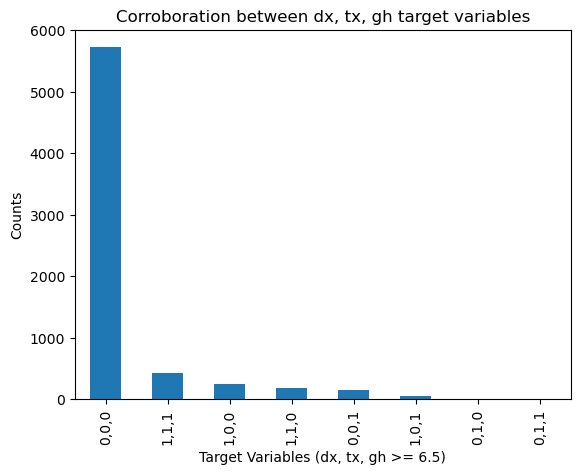

In [119]:
target_counts = pd.read_sql_query("SELECT COUNT(dx) AS counts, dx, tx, gh >= 6.5 FROM nhgh GROUP BY dx, tx, gh >= 6.5 ORDER BY counts DESC", con)
target_counts["counts"].plot.bar()
xticks = target_counts[["dx", "tx", "gh >= 6.5"]].astype(str).apply(lambda x : ",".join(x), axis=1)
plt.xticks(range(target_counts.shape[0]), xticks)
plt.xlabel("Target Variables (dx, tx, gh >= 6.5)")
plt.ylabel("Counts")
plt.title("Corroboration between dx, tx, gh target variables")
plt.show()

The distribution suggests that for the most part there is corroboration between the variables, however there are small number of inconsistencies. If we were to create a model using either of these 2 columns there would be a very strong correlation with glychohaemoglobin percentage, however it would not be a very useful input variable since it is the variable we are trying to infer. Importantly we do not have any missing values in these columns. We could potentially combine all 3 variables into a label of diabetes or non diabetes

In [120]:
target_counts.groupby("gh >= 6.5")["counts"].sum() / target_counts["counts"].sum()

gh >= 6.5
0    0.907579
1    0.092421
Name: counts, dtype: float64

The distribution of our target variable is also quite imbalanced, with just under 10% of individuals having diabetes. This may have an impact during model development

### Variable distributions and relationships

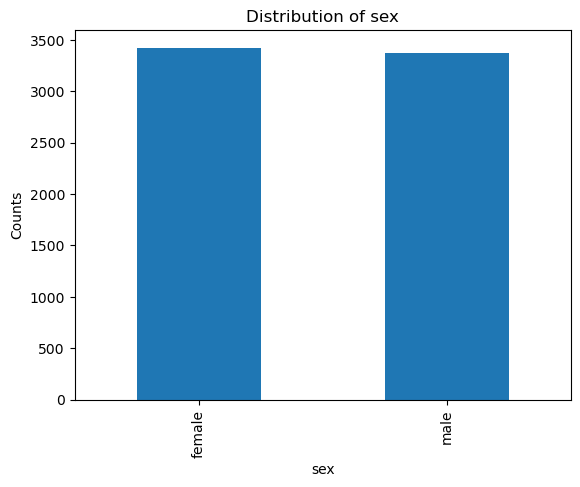

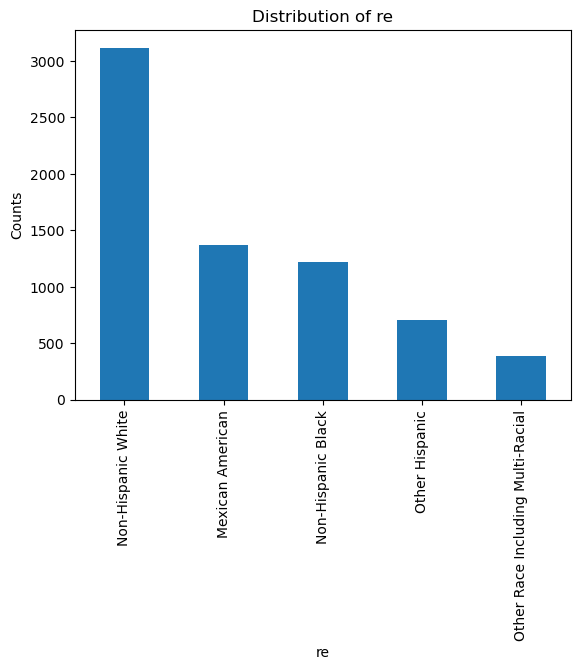

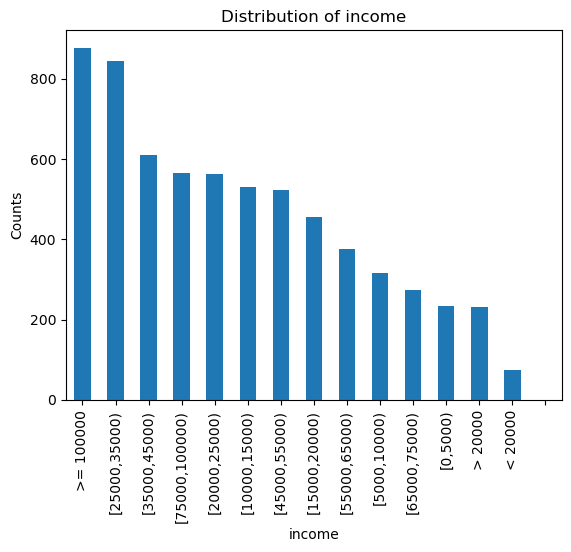

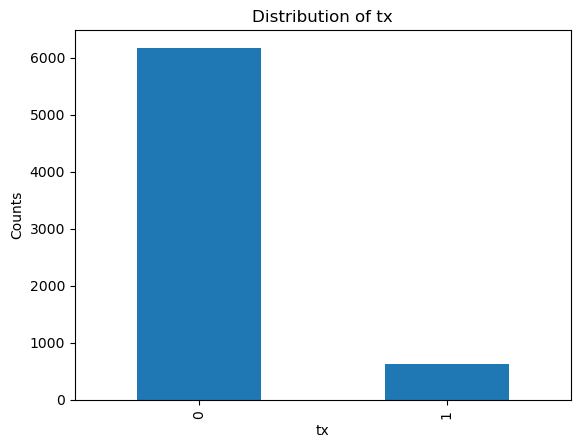

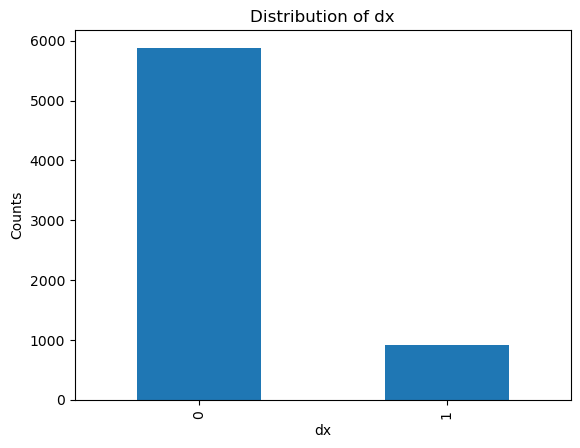

In [121]:
for v in var_type["categorical"]:
    if v != "seqn":
        df = pd.read_sql_query("SELECT COUNT({}) AS counts, {} FROM nhgh GROUP BY {} ORDER BY counts DESC".format(v, v, v), con)
        df["counts"].plot.bar(title="Distribution of {}".format(v),
                                    ylabel="Counts", xlabel="{}".format(v))
        plt.xticks(range(df.shape[0]), df[v])
        plt.show()

The income variable is ordinal, but the categories are problematic as the > 20000 and < 20000 overlap with the other categories. To deal with this we could turn the variable into a binary variable where everything is > 20000 and < 20000, or we could merge these 2 categories with the value closest to them. Also noted that there are 320 NA values in this variable that will have to be dealt with later.

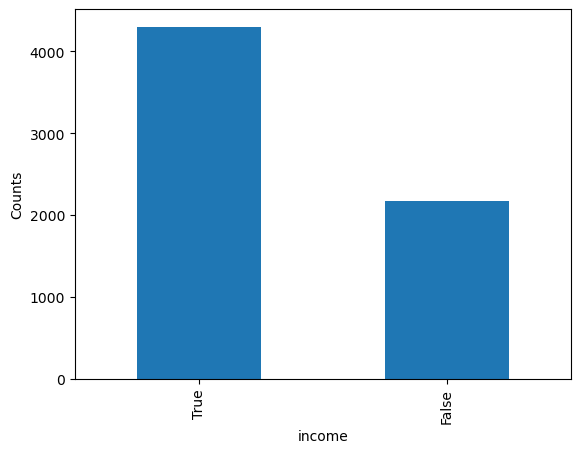

In [122]:
import re

def mt20000(x):
    if pd.isna(x):
        return x
    matches = re.findall("[0-9]+", x)
    if len(matches) > 1:
        return int(matches[0]) > 20000
    else:
        return x.find(">") > -1

income_binary = pd.read_sql_query("SELECT income FROM nhgh", con)["income"].apply(mt20000)
income_binary.value_counts().plot.bar(ylabel="Counts")
plt.show()

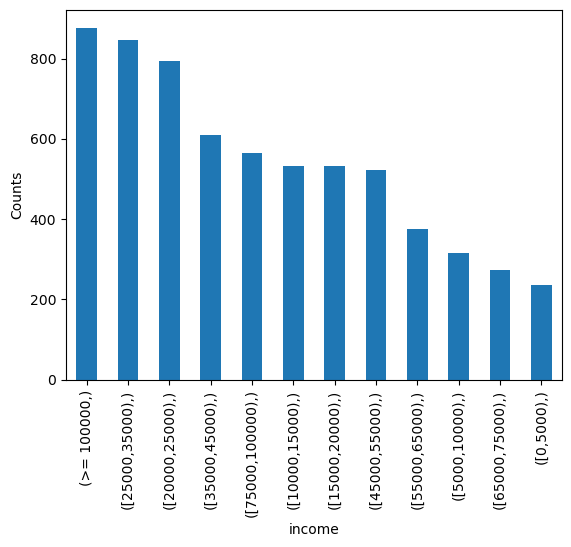

In [123]:
income = pd.read_sql_query("SELECT income FROM nhgh", con).replace({"> 20000" : "[20000,25000)", "< 20000" : "[15000,20000)"})
income.value_counts().plot.bar(ylabel="Counts")
plt.show()

We then take a look at the continuous variables distributions

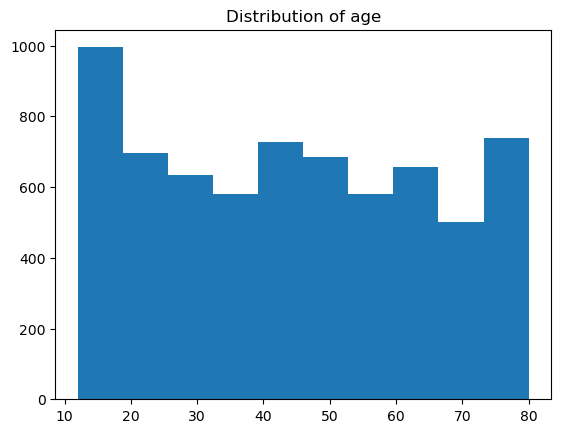

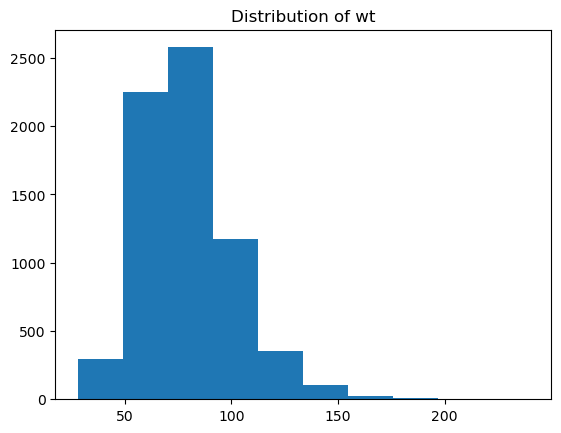

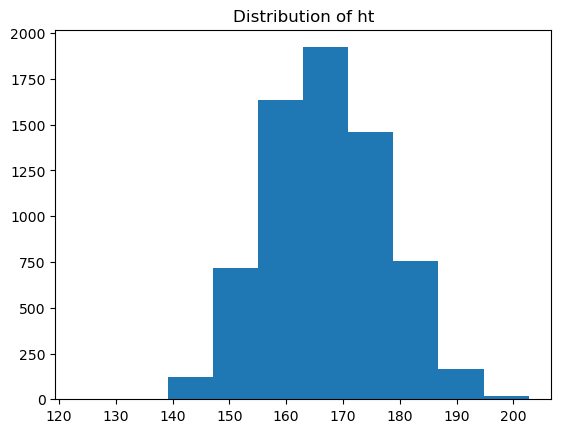

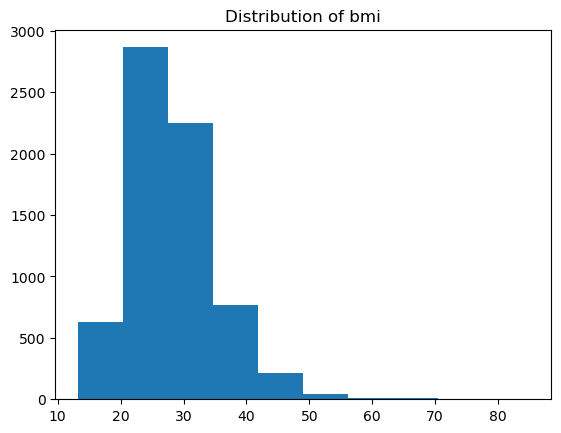

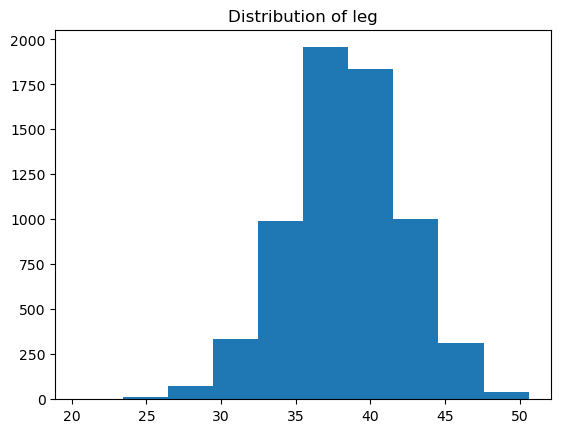

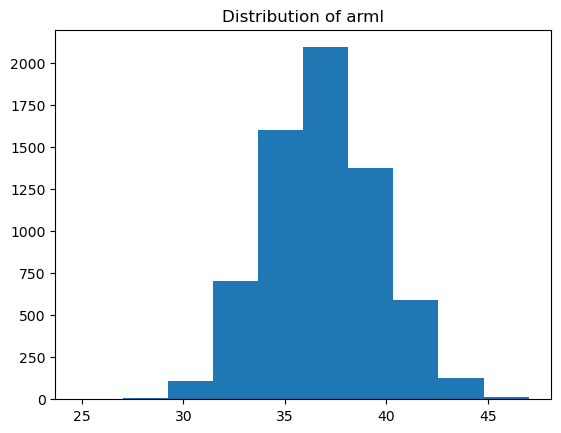

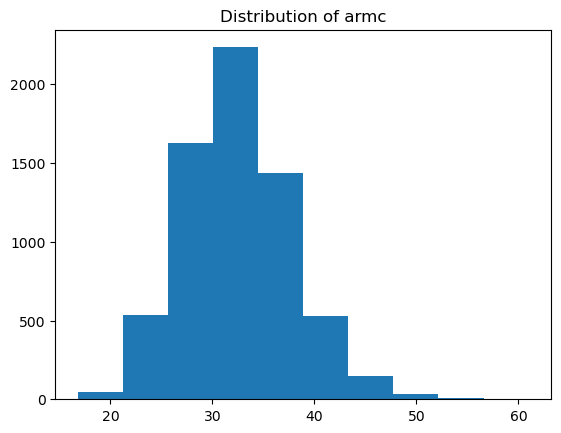

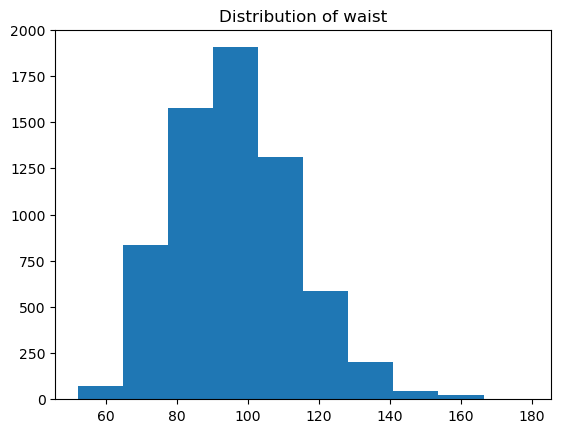

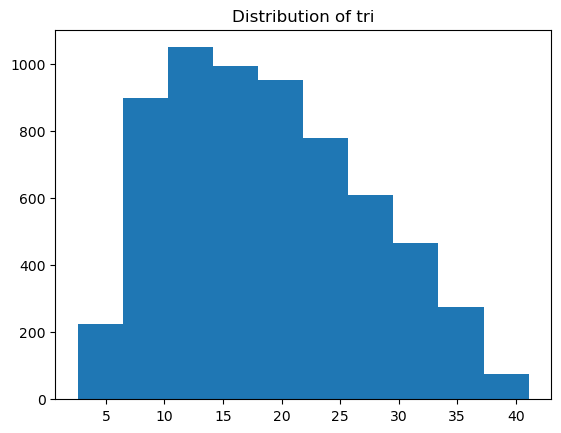

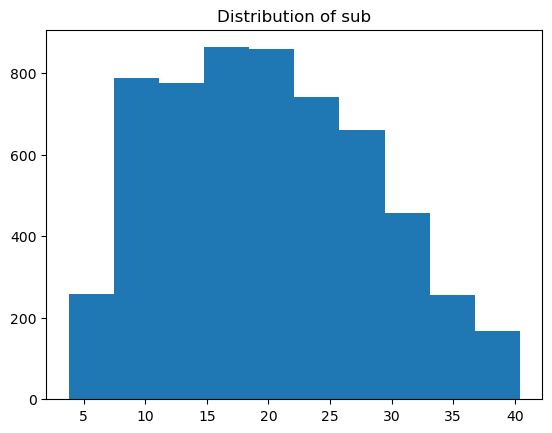

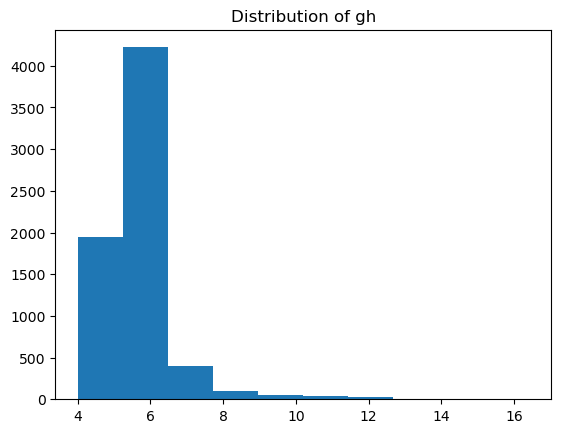

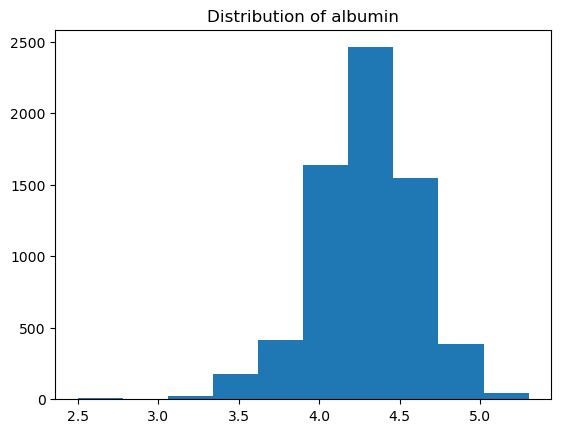

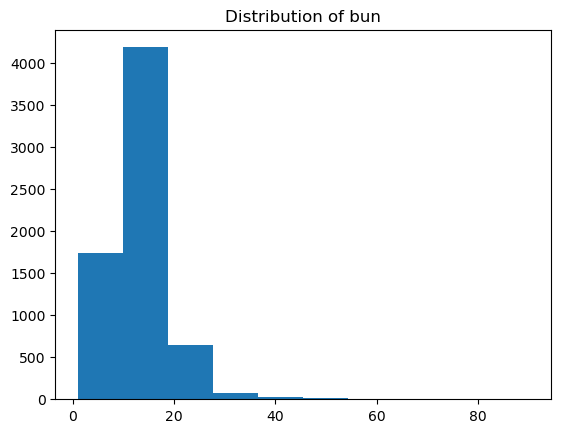

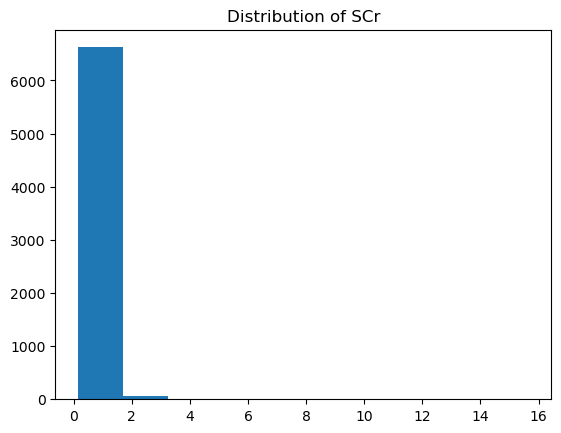

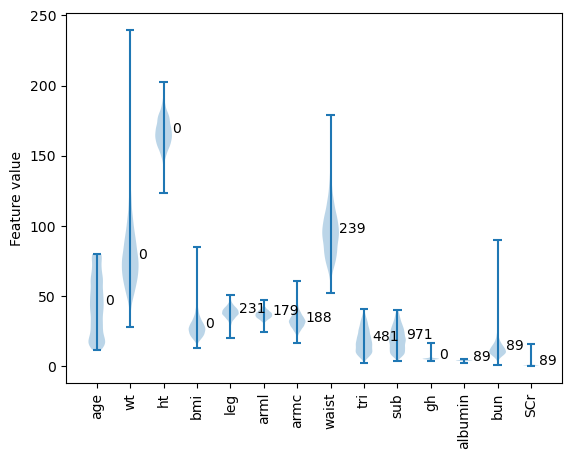

In [124]:
vecs = []
null_counts = []
for v in var_type["continuous"]:
    vecs.append(pd.read_sql_query("SELECT {} FROM nhgh WHERE {} IS NOT NULL".format(v, v), con)[v])
    plt.hist(vecs[-1])
    plt.title("Distribution of {}".format(v))
    plt.show()
    null_counts.append(pd.read_sql_query("SELECT COUNT(*) AS null_count FROM nhgh WHERE {} IS NULL".format(v), con)["null_count"].item())
plt.violinplot(vecs)
plt.xticks(range(1, len(var_type["continuous"])+1), var_type["continuous"], rotation=90)
plt.ylabel("Feature value")
for i, n in enumerate(null_counts):
    plt.text(i + 1.25, vecs[i].median(), n)
plt.show()

From the figure above we can note down several observations
1. All the specific body part measurements have null values, with subscapular skinfold having the highest number of null values
2. There is a small number of patients with no albumin/urea/creatinine
3. The range of values is mostly within expected values, although there seem to be some pretty overweight individuals which I am uncertain is an error or a valid recording.
4. Most of the continuous variables seem to be normally distributed, except for age, which appears to be fairly uniform, and bun and SCr which is heavily right skewed

Next we look at the correlation between these variables

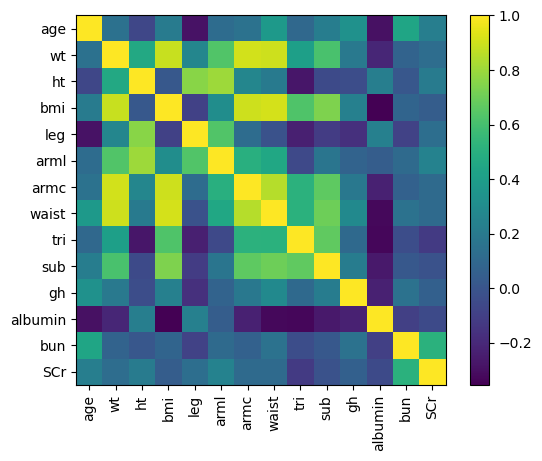

In [125]:
plt.imshow(pd.read_sql_query("SELECT {} FROM nhgh".format(",".join(var_type["continuous"])), con).corr())
plt.xticks(range(len(var_type["continuous"])), var_type["continuous"], rotation=90)
plt.yticks(range(len(var_type["continuous"])), var_type["continuous"])
plt.colorbar()
plt.show()

From the correlation we can see that the body fat measurements are generally highly correlated with one another and with the weight and BMI variables as well, which makes sense biologically. Given the large number of null values in these variables, it may be possible to use these correlated variables to fill in the null values or potentially to use weight and bmi as proxies for everything else since those have no null values.

In [126]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
contvars = pd.get_dummies(pd.read_sql_query("SELECT {} FROM nhgh WHERE {}".format(",".join(var_type["continuous"]), " IS NOT NULL AND ".join(var_type["continuous"]) + " IS NOT NULL"), con))
target = pd.read_sql_query("SELECT gh FROM nhgh WHERE {}".format(" IS NOT NULL AND ".join(var_type["continuous"]) + " IS NOT NULL"), con)
mi_scores = {"continuous" : mutual_info_regression(contvars, target), 
             "discrete" : mutual_info_classif(contvars, target >= 6.5)}
mi_scores = pd.DataFrame(mi_scores, index=var_type["continuous"])
mi_scores / mi_scores.max(axis=0)

c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

,continuous,discrete
age,0.054956,0.145511
wt,0.006821,0.034867
ht,0.000000,0.000000
bmi,0.020748,0.076375
leg,0.013914,0.051968
arml,0.002071,0.000000
armc,0.006744,0.034575
waist,0.024178,0.114294
tri,0.007566,0.013963
sub,0.013947,0.057431


In [127]:
catvars = pd.get_dummies(pd.read_sql_query("SELECT {} FROM nhgh WHERE {}".format(",".join(var_type["categorical"]), " IS NOT NULL AND ".join(var_type["categorical"]) + " IS NOT NULL"), con))
target = pd.read_sql_query("SELECT gh FROM nhgh WHERE {}".format(" IS NOT NULL AND ".join(var_type["categorical"]) + " IS NOT NULL"), con)
mi_scores = {"continuous" : mutual_info_regression(catvars, target), 
             "discrete" : mutual_info_classif(catvars, target >= 6.5)}
mi_scores = pd.DataFrame(mi_scores, index=catvars.columns)
mi_scores / mi_scores.max(axis=0)

c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\David Chong\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

,continuous,discrete
tx,1.000000,1.000000
dx,0.895657,0.922282
sex_female,0.144162,0.043542
sex_male,0.112978,0.066207
re_Mexican American,0.056236,0.000000
re_Non-Hispanic Black,0.042652,0.000000
re_Non-Hispanic White,0.101312,0.000000
re_Other Hispanic,0.000000,0.000000
re_Other Race Including Multi-Racial,0.000000,0.000000
income_< 20000,0.039241,0.004338
